In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read in data and create time features

In [2]:
project_a1e0 = pd.read_csv('../../capstone_data/Azimuth/project_e871.csv')
project_a1e0.dropna(inplace=True)
project_a1e0.info()

project_a1e0['t'] = pd.to_datetime(project_a1e0['t'], format='%Y-%m-%d %H:%M:%S')
project_a1e0.sort_values('t',inplace=True)
project_a1e0 = project_a1e0.set_index('t')
project_a1e0['year'] = project_a1e0.index.year
project_a1e0['month'] = project_a1e0.index.month
project_a1e0['day'] = project_a1e0.index.day
project_a1e0['dayofweek'] = project_a1e0.index.dayofweek
project_a1e0['hour'] = project_a1e0.index.hour

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31371 entries, 14 to 31535
Data columns (total 9 columns):
project_id    31371 non-null object
t             31371 non-null object
relay         31371 non-null float64
load_v1rms    31371 non-null float64
load_v2rms    31371 non-null float64
load_v3rms    31371 non-null float64
load_i1rms    31371 non-null float64
load_i2rms    31371 non-null float64
laod_i3rms    31371 non-null float64
dtypes: float64(7), object(2)
memory usage: 2.4+ MB


## Reduce Relay signal to 0s and 1s

In [3]:
project_a1e0['relay_est'] = project_a1e0['relay'].apply(lambda x: 0 if x == 1.0 else 1)

In [4]:
project_a1e0['relay_est'].value_counts()

0    31336
1       35
Name: relay_est, dtype: int64

## Identify records where time continuity is broken

In [5]:
# tagging periods where the proceeding datapoint is not 5 minutes
time = pd.Series(project_a1e0.index)
time2 = pd.Series(project_a1e0.index).shift(1)
ser = pd.Series(time - time2)
ser = ser.apply(lambda x: None if x!=pd.to_timedelta('0 days 00:05:00')else 1)
project_a1e0['t_diff']= pd.Series(ser).values

## Plots for examining data

In [6]:
def plot_all_data(df,columns):
    years = df['year'].unique()
    y_m_combinations = []
    for y in years: 
        months = df[(df['year'] == y)]['month'].unique()
        for m in months:
            y_m = (y,m)
            y_m_combinations.append(y_m)

    fig, axs = plt.subplots(len(y_m_combinations), figsize=(14, 5*len(y_m_combinations)))
    for ax, c in zip(axs,y_m_combinations):
        temp = df[(df['year'] == c[0]) & (df['month'] == c[1])]
        for col in columns:
            ax.plot(temp.index, temp[col]/df[col].max())
        ax.set_title('timeseries for {}, {}'.format(c[0],c[1]))
    plt.show()
    pass

In [7]:
def plot_time_frame(df,start,end,columns):
    '''
    Plot the timeseries for a given period of time
    PARAMETERS
    ------------
    df : Pandas DataFrame with DatetimeIndex
    start: string in format 'YYYY-MM-DD HH:MM:SS'
    end: string in format 'YYYY-MM-DD HH:MM:SS'
    columns: list of column names
    RETURNS
    -------
    None: plots the graphs
    '''
    temp = df.loc[(df.index>=start)&(df.index<end)]
    years = temp['year'].unique()
    y_m_combinations = []
    for y in years: 
        months = temp[(temp['year'] == y)]['month'].unique()
        for m in months:
            y_m = (y,m)
            y_m_combinations.append(y_m)
    
    if len(y_m_combinations) ==1:
        temp2 = temp[(temp['year'] == y_m_combinations[0][0]) & (temp['month'] == y_m_combinations[0][1])]
        plt.figure(figsize=(14,4))
        for col in columns:
            plt.plot(temp2.index, temp2[col]/df[col].max())
        plt.title('timeseries for {}, {}'.format(y_m_combinations[0][0],y_m_combinations[0][0]))
        
    else:
        fig, axs = plt.subplots(len(y_m_combinations), figsize=(14, len(y_m_combinations)*4))
        for ax, c in zip(axs,y_m_combinations):
            temp2 = temp[(temp['year'] == c[0]) & (temp['month'] == c[1])]
            for col in columns:
                ax.plot(temp2.index, temp2[col]/df[col].max())
            ax.set_title('timeseries for {}, {}'.format(c[0],c[1]))
    plt.show()
    pass

In [11]:
project_a1e0.index.min()

Timestamp('2016-11-21 18:35:00')

In [13]:
def calculate_power(df):
    '''
    Calculate total power for that site
    PARAMETERS:
    -----------
    df: Pandas DataFrame with DatetimeIndex
    RETURNS:
    -----------
    df: Pandas DataFrame with DatetimeIndex
    '''
    df['power_1'] = df['load_v1rms'] * df['load_i1rms']
    df['power_2'] = df['load_v2rms'] * df['load_i2rms']
    df['power_3'] = df['load_v3rms'] * df['laod_i3rms']
    df['power_all'] = ( df['power_1'] +df['power_2']+df['power_3'] ) * 5./12
    return df

In [14]:
project_a1e0 = calculate_power(project_a1e0)

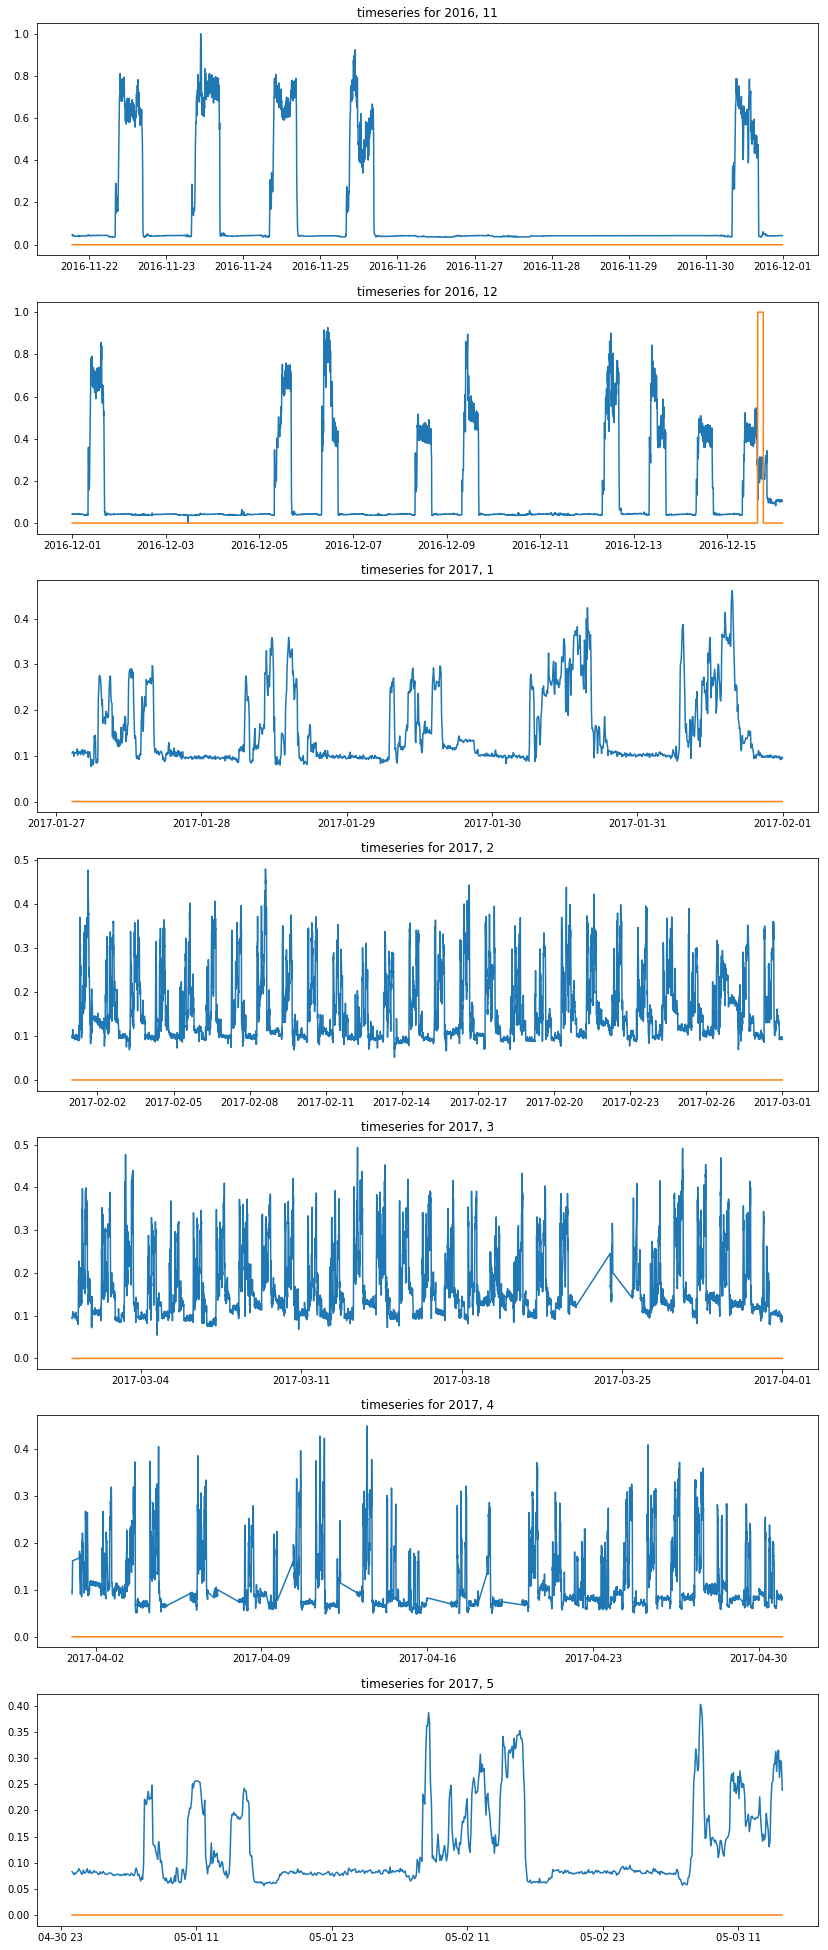

In [15]:
plot_all_data(project_a1e0, columns=['power_all','relay_est'])

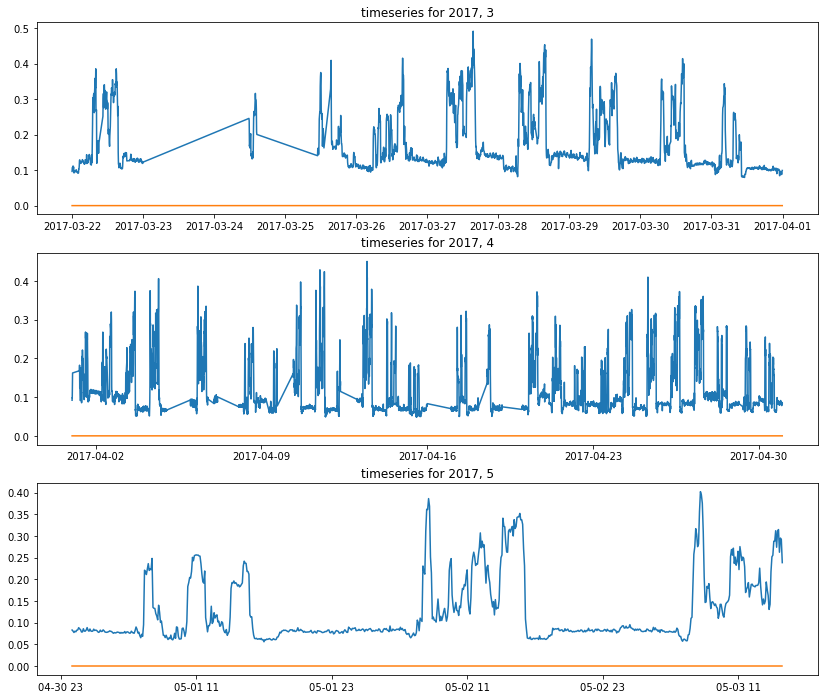

In [19]:
plot_time_frame(project_a1e0,'2017-03-22 00:00:00','2017-05-20 00:00:00',columns=['power_all','relay_est'])

In [20]:
bad_data = [('2016-11-20 00:00:00','2017-01-25 00:00:00'),
            ('2017-03-22 00:00:00','2017-05-20 00:00:00')]

## Function to label and remove bad data periods

In [21]:
def label_bad_data(df, dates):
    df['data_issue']=0
    for d in dates:
        df.loc[(df.index>=d[0])&(df.index<d[1]),'data_issue'] = 1
    return df

In [22]:
df = label_bad_data(project_a1e0, bad_data)
df.data_issue.value_counts()

1    15964
0    15407
Name: data_issue, dtype: int64

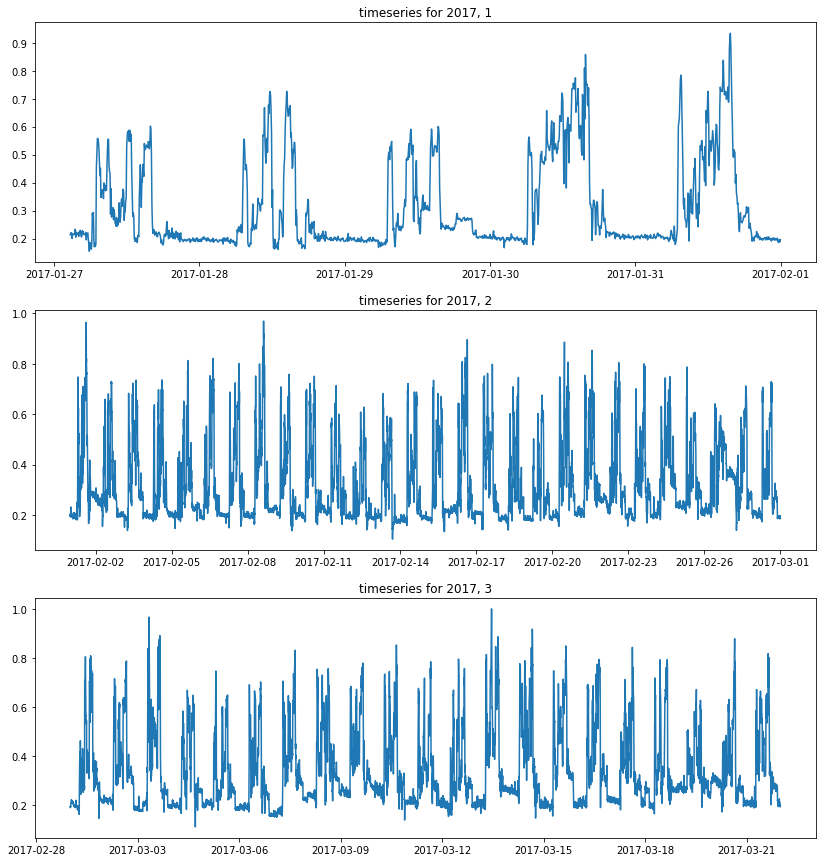

In [24]:
df2 = df[df['data_issue']!=1]
plot_all_data(df2,['power_all'])

## Write data to csv

In [26]:
df2.to_csv('../../capstone_data/Azimuth/clean/project_e871_clean.csv', index=True)

In [201]:
def outage_smoothing(df, feature, time_window):
    '''
    Calculates the aggregate value of a column for a given time_window starting
    before each point
    PARAMETERS
    ----------
    df: Pandas DataFrame
    feature: column name of feature to shift
    time_window: time window to aggregate over, use convention used in Pandas
                 reindex or rolling:http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    func: Aggregate function to use
    '''
    temp = pd.DataFrame(df[feature].shift(1))
    mean = temp.rolling(time_window,min_periods=1).mean()
    mean = mean.fillna(temp.bfill())
    std = temp.rolling(time_window,min_periods=1).std()
    std = std.fillna(temp.bfill())
    combined = (mean - 1 * std)
    result = np.where(temp < combined,None, temp)
    df[feature] = result
    df[feature] = df[feature].fillna(method='ffill')
    return df